# DATA PREPROCESSING PIPELINE

## Import 

In [6]:
# Importar módulos necesarios
import pandas as pd
import numpy as np
import math
from pathlib import Path
import sii_utils
sii_utils.suppress_warnings('pw')

## Cargar Configuraciones & dataset

In [7]:
import yaml
with open('..\\config_file.yml', 'r') as file:
    cfg = yaml.safe_load(file)
cfg

{'path': {'Home': '..\\\\',
  'Bronze': 'data/Bronze/',
  'Silver': 'data/Silver/',
  'Gold': 'data/Gold/',
  'Artefactos': 'artefactos/'},
 'data_files': {'Bronze': 'GOVMS_BA_PRED_ANON.tab',
  'Silver': 'Silver_data.csv',
  'Gold': 'Gold_data.csv'},
 'model_files': {'Log_metrics': 'Log_metrics.txt', 'Model_name': 'Model.pkl'}}

In [8]:
### Carga el conjunto de datos desde un archivo CSV y realiza algunas operaciones de preprocesamiento.
# Construir la ruta al archivo CSV utilizando la biblioteca pathlib
#path_datasilver = Path(cfg['path']['Home'], cfg['path']['Bronze'], 'GOVMS_BA_PRED_ANONv2.csv')
path_datasilver = Path(cfg['path']['Home'], cfg['path']['Bronze'], 'nuevoDF_CH.csv')


# Imprimir la ruta del archivo
print(f'Ruta del archivo: {path_datasilver}')

# Cargar el DataFrame desde el archivo CSV utilizando pandas
df = pd.read_csv(path_datasilver, sep=';')

# Aplicar la función de conversión de tipos del módulo sii_utils
df = sii_utils._convert_types(df)

# Imprimir la forma del DataFrame
print(f'Dimensionalidad del DataFrame: {df.shape}')

# Mostrar las primeras 4 filas del DataFrame
print('Primeras 4 filas del DataFrame:')
display(df.head(4))


Ruta del archivo: ..\data\Bronze\nuevoDF_CH.csv
Leyendo archivo .yml : config_types.yml
Conversion de data finalizada
Dimensionalidad del DataFrame: (5000, 105)
Primeras 4 filas del DataFrame:


,CONT_RUT,CONT_DV,campo_1,campo_2,campo_3,campo_4,campo_5,campo_6,campo_7,campo_8,...,campo_94,campo_95,campo_96,campo_97,campo_98,campo_99,campo_100,campo_101,campo_102,campo_103
0,72,3,nan,nan,nan,1.0,14D1,nan,nan,nan,...,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,nan
1,913,4,nan,nan,nan,1.0,14D1,nan,nan,nan,...,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,nan
2,1059,7,nan,nan,nan,1.0,14D1,nan,nan,nan,...,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,nan
3,1258,7,nan,nan,nan,1.0,14D1,nan,nan,nan,...,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,nan


In [9]:
### REVISAR SI ES NECESARIO //
mask_18470=(df["campo_1"]!="nan")
df_1847=df.loc[mask_18470]
df_1847.shape

(304, 105)

## Aplicacion de filtros

Se aplica los diferentes filtrosÑ



In [10]:
# Calcular la frecuencia de valores en el campo_50
conteo_campo_50 = df['campo_50'].value_counts()
conteo_campo_50

campo_50
nan    4171
0.0     790
1.0      39
Name: count, dtype: int64

In [11]:
## Filtra el DataFrame para excluir las filas donde el campo_50 es igual a "1.0", el campo_52 es igual a "1.0" y el campo_48 es igual a "INACTIVOS".

# Crear máscara para excluir filas donde campo_50 es igual a "1.0"
mask_tg = (df["campo_50"] != "1.0")
print(f'Máscara para campo_50 != "1.0", Shape: {mask_tg.sum()}')

# Crear máscara para excluir filas donde campo_52 es igual a "1.0"
mask_agresivo = (df["campo_52"] != "1.0")
print(f'Máscara para campo_52 != "1.0", Shape: {mask_agresivo.sum()}')

# Crear máscara para excluir filas donde campo_48 es igual a "INACTIVOS"
mask_seg_cat = (df["campo_48"] != "INACTIVOS")
print(f'Máscara para campo_48 != "INACTIVOS", Shape: {mask_seg_cat.sum()}')

# Aplicar las máscaras para filtrar el DataFrame
df = df.loc[mask_tg & mask_agresivo & mask_seg_cat]

# Imprimir la forma del DataFrame
print(f'Dimensionalidad del DataFrame: {df.shape}')

Máscara para campo_50 != "1.0", Shape: 4961
Máscara para campo_52 != "1.0", Shape: 4998
Máscara para campo_48 != "INACTIVOS", Shape: 4177
Dimensionalidad del DataFrame: (4136, 105)


## Seleccion de columnas

Utilizando el plan de acciones, seleccionamos las columnas que se van a utilizar para modelar el fenomeno

In [12]:
# Construir la ruta al archivo del plan revisado
path_plan = Path(cfg['path']['Home'], 'data/seleccion_inicial.txt')
# Intentar leer el plan revisado desde el archivo txt
seleccionadas = []
try:
    with open(path_plan, 'r') as file:
        for line in file:
            seleccionadas.append(line.replace('\n', '').strip())
    print(f'Archivo leido correctamente')
    print(f'Variables a utilizar {len(seleccionadas)}')
except FileNotFoundError:
    # Capturar específicamente la excepción FileNotFoundError
    print(f'No se encontró el archivo en la ruta {path_plan}')
    print(f'Se usarán todas las variables del dataframe')
    seleccionadas = list(df.columns)
    print(f'Variables a utilizar {len(seleccionadas)}')
except Exception as e:
    # Capturar cualquier otra excepción
    raise Exception(f'Error inesperado: {str(e)}') from None

## verificar que las variables leidas se encuentren en el dataset
seleccionadas = list(set(seleccionadas)&set(list(df.columns)))
print(f'Variables a utilizar posterior verificacion {len(seleccionadas)}')

Archivo leido correctamente
Variables a utilizar 59
Variables a utilizar posterior verificacion 59


In [13]:
### seleccionar variables a utilizar
df = df.loc[:,['CONT_RUT', 'CONT_DV']+seleccionadas ]

## Aplicacion de plan de nulos

Se aplica la imputaciones de los valores nulos dependiendo de cada variable y el plan de accion

In [14]:
# Construir la ruta al archivo del plan revisado
path_null_treatment_config= Path(cfg['path']['Home'], 'data/null_treatment_config.yml')

# Cargar la configuración desde el archivo YAML
with open(path_null_treatment_config, 'r') as file:
    null_treatment_config = yaml.safe_load(file)

# Aplicar la estrategia de manejo de nulos
df = sii_utils.apply_null_handling_strategy(df, null_treatment_config, verbose = 0)
print(df.shape)

Aplicando estrategia de imputacion de datos por columna
Aplicando estrategia general de imputacion de datos
(4126, 61)


## Ingenieria de Caracteristicas

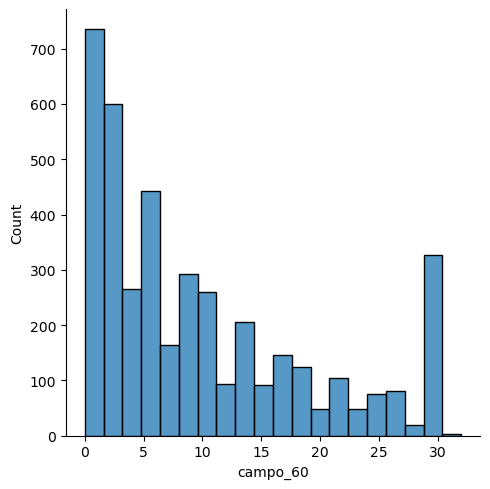

In [15]:
#df.groupby(['campo_60']).size()
import seaborn as sns
sns.displot(df['campo_60'])

In [16]:
# CREAMOS ESTAS NUEVAS VARIABLES MENCIONADAS

# Esta variable campo_104 es una combinacion entre las variables campo_60 y ANTIGUEDAD_DESDE_CONSTITUCION
# Campo 60 sin valores nulos
# df['campo_104'] = np.where(df['campo_60'].isna() == True,
#                                         df['campo_57'],
#                                         df['campo_60'])


df['campo_104'] = df['campo_60'].copy()
df.loc[df['campo_104'].isna(), 'campo_104'] = df.loc[df['campo_104'].isna(), 'campo_57']
df.loc[df['campo_104'].isna(), 'campo_104'] = -1

## Categorizacion de variable continua





1: nulo

2: [0-2)

3: [2-5)

4: [5-10)

5: [10-29)

6: [29+)




In [17]:
#df['campo_60_cat'] = np.where(df['campo_104']=='NULLS' , -1, df['campo_60'])
df['campo_60_cat'] = df['campo_60'].copy()
df.loc[df['campo_104']=='NULLS', 'campo_60_cat'] = -1


values = [-math.inf, 0, 2, 5, 10, 29, math.inf]

cat = [1,2,3,4,5,6]
"""
1: nulo
2: [0-2)
3: [2-5)
4: [5-10)
5: [10-29)
6: [29+)
"""
#dataframe_dropcol['campo_60_cat'] = dataframe_dropcol['campo_60_cat'].astype('object')
df['campo_60_cat'] = pd.cut(x=df['campo_60_cat'], bins=values, labels = cat, right=False)
df['campo_60_cat'] = df['campo_60_cat'].astype('object')
df['campo_60_cat'].value_counts()

campo_60_cat
5    1296
4     899
3     866
2     735
6     330
Name: count, dtype: int64

In [18]:
%time
values_ind=[]
for index,row in df.iterrows():
    
    f22_3at =row["campo_10"]
    f29_46pt=row["campo_11"]
    f50_36pt=row["campo_12"]
    
    if f22_3at=='1.0' or f29_46pt=='1.0' or f50_36pt=='1.0':
        
        values_ind.append(1)
        
    else:
        values_ind.append(0)

CPU times: total: 0 ns
Wall time: 0 ns


In [19]:
values_ind = (df[['campo_10', 'campo_11', 'campo_12']]=='1.0').sum(axis = 1)
df["Presenta_union"] = (values_ind >= 1).astype(int).astype(str)

In [20]:
#df.isna().sum().to_frame('N').sort_values('N')

In [21]:
df['campo_100'].value_counts()
df['campo_100'].dtypes

dtype('float64')

## Exportar dataset

In [22]:
path_save_data=Path(cfg['path']['Home'],cfg['path']['Silver'])

## EXPORTAR DATAFRAME
name_file=f'Silver_DJ_preprocessed.csv'
path_file=Path(path_save_data,name_file)
df.to_csv(path_file,sep=';',index=False)

## EXPORTAR DATAFRAME COLUMN TYPES
df_dtypes = df.dtypes.to_frame('Tipo').reset_index().rename({'index':'Variable'}, axis = 1)
name_file=f'Silver_DJ_preprocessed_var_types.csv'
path_file=Path(path_save_data,name_file)
df_dtypes.to_csv(path_file,sep=';',index=False)
